In [6]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
%config InlineBackend.figure_formats = ['svg'] 

## Assignment 4.1

[[-1.3333333333333335, 0], [0.0, 0], [1.333333333333333, 0]]
1.2018504251546631


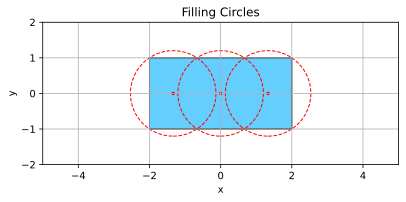

In [ ]:
def calculate_circles(l: float, w: float, nc: int):
    d = l / (2.0 * nc)
    r = np.sqrt(0.25*w**2 + d**2)
    c = [[-l/2 + (2*i+1)*d,0] for i in range(nc)]

    return c, r 

def plot_circles(ax, c: list[float], r:float):
    for center in c:
        circ = Circle(center, r, edgecolor='r', fill=False, linestyle='--')
        ax.add_patch(circ)
        ax.scatter(center[0], center[1], s=6, color='r', label=None)

def plot_car(ax, l: float, w: float):
    car = Rectangle((-l/2,-w/2),l,w,facecolor="#64ceff",edgecolor='k')
    ax.add_patch(car)
    
l = 4
w = 2
nc = 3
c, r = calculate_circles(l, w, nc)
print(c)
print(r)


fig, ax = plt.subplots()
plot_car(ax, l, w)
plot_circles(ax, c, r)
ax.set_xlim([-5,5])
ax.set_ylim([-2,2])
ax.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Filling Circles")
ax.set_aspect('equal')
# plt.savefig("figs/4.1.pdf", bbox_inches="tight", pad_inches=0.1)

## Assignemnt 4.2

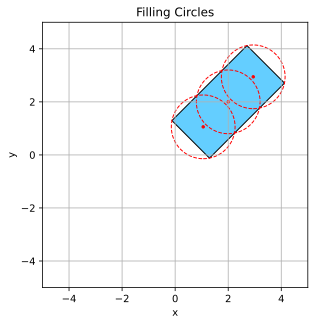

In [ ]:
def rotate2d(vector, angle):
    c = np.cos(angle)
    s = np.sin(angle)
    x = vector[0]*c - vector[1]*s 
    y = vector[0]*s + vector[1]*c 
    return np.array((x, y))

def calculate_circles(center:np.ndarray, rotation:float, l: float, w: float, nc: int):
    d = l / (2.0 * nc)
    r = np.sqrt(0.25*w**2 + d**2)
    c = [rotate2d([-l/2 + (2*i+1)*d, 0], rotation) + center for i in range(nc)]

    return c, r 

def plot_circles(ax, c: list[float], r:float):
    for center in c:
        circ = Circle(center, r, edgecolor='r', fill=False, linestyle='--')
        ax.add_patch(circ)
        ax.scatter(center[0], center[1], s=6, color='r', label=None)

def plot_car(ax, center:np.ndarray, rotation:float, l: float, w: float):
    car = Rectangle((center[0]-l/2,center[1]-w/2),l,w,angle=rotation*180/np.pi,rotation_point='center',facecolor="#64ceff",edgecolor='k')
    ax.add_patch(car)

l = 4
w = 2
nc = 3
center = (2,2)
rotation = np.pi/4
c, r = calculate_circles(center, rotation, l, w, nc)
fig, ax = plt.subplots()
plot_car(ax, center, rotation, l, w)
plot_circles(ax, c, r)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Filling Circles")
ax.set_aspect('equal')
# plt.savefig("figs/4.2.pdf", bbox_inches="tight", pad_inches=0.1)

## Assignment 4.4

In [148]:
from typing import Callable, Tuple
import casadi as cs
from given4.parameters import VehicleParameters
from given4.animation import AnimateParking
from given4.plotting import plot_state_trajectory, plot_input_sequence
from matplotlib.patches import Rectangle
from rcracers.simulator.dynamics import KinematicBicycle
import numpy as np
import matplotlib.pyplot as plt
from rcracers.simulator import simulate
from time import perf_counter

PARK_DIMS = np.array((0.25, 0.12))

def forward_euler(f, ts) -> Callable:
    def fw_eul(x,u):
        return x + f(x,u) * ts
    return fw_eul

def runge_kutta4(f, ts) -> Callable:
    def rk4_dyn(x,u):
        s1 = f(x,u)
        s2 = f(x + 0.5 * ts * s1, u)
        s3 = f(x + 0.5 * ts * s2, u)
        s4 = f(x + ts * s3, u)
        x_next =  x + ts / 6.0 * (s1 + 2.0 * s2 + 2.0 * s3 + s4)
        return x_next 
    
    return rk4_dyn

def exact_integration(f, ts) -> Callable:
    """Ground truth for the integration
    
    Integrate the given dynamics using scipy.integrate.odeint, which is very accurate in 
    comparison to the methods we implement in this settings, allowing it to serve as a 
    reference to compare against.

    Args:
        f (dynamics): The dynamics to integrate (x,u) -> xdot
        ts (_type_): Sampling time 

    Returns:
        Callable: Discrete-time dynamics (x, u) -> x+ 
    """
    from scipy.integrate import odeint  # Load scipy integrator as a ground truth
    def dt_dyn(x, u):
        f_wrap = lambda x, t: np.array(f(x, u)).reshape([x.size])
        y = odeint(f_wrap, x.reshape([x.size]), [0, ts])
        return y[-1].reshape((x.size,))
    return dt_dyn

def plot_states_separately(x_sequence):
    plt.subplot(4,1,1)
    plt.title("Position x")
    plt.plot(x_sequence[:,0].squeeze(), marker=".")
    plt.ylabel("$p_x$");
    plt.subplot(4,1,2)
    plt.title("Position y")
    plt.plot(x_sequence[:,1].squeeze(), marker=".")
    plt.ylabel("$y$")
    plt.subplot(4,1,3)
    plt.title("Angle")
    plt.plot(x_sequence[:,2].squeeze(), marker=".")
    plt.ylabel("$\\psi$")
    plt.subplot(4,1,4)
    plt.title("Velocity")
    plt.plot(x_sequence[:,3].squeeze(), marker=".")
    plt.ylabel("$v$")
    plt.xlabel("$t$")
    plt.tight_layout()

def plot_input_sequence(u_sequence, params: VehicleParameters):
    plt.subplot(2,2, (1,3))
    plt.title("Control actions")
    plt.plot(u_sequence[:,0], u_sequence[:,1], marker=".")
    bounds = Rectangle(np.array((params.min_drive, -params.max_steer)), params.max_drive-params.min_drive, 2*params.max_steer, fill=False)
    plt.gca().add_patch(bounds)
    plt.xlabel("$a$")
    plt.ylabel("$\\delta$");
    plt.subplot(2,2,2)
    plt.title("Steering angle")
    plt.plot(u_sequence[:,1].squeeze(), marker=".")
    style=dict(linestyle="--", color="black")
    plt.axhline(params.max_steer, **style)
    plt.axhline(-params.max_steer, **style)
    plt.ylabel("$\\delta$");
    plt.subplot(2,2,4)
    plt.title("Acceleration")
    plt.plot(u_sequence[:,0].squeeze(), marker=".")
    plt.axhline(params.min_drive, **style)
    plt.axhline(-params.max_drive, **style)
    plt.ylabel("$a$");
    plt.xlabel("$t$")
    plt.tight_layout()


def plot_state_trajectory(x_sequence, title: str = "Trajectory", ax = None, color="tab:blue", label: str=""):
    if ax is None:
        ax = plt.gca()
    ax.set_title(title)
    car_params = VehicleParameters()
    parking_area = Rectangle(-0.5*PARK_DIMS, *PARK_DIMS, ec="tab:green", fill=False)
    ax.add_patch(parking_area)
    extra_arg = dict()
    for i, xt in enumerate(x_sequence):
        if i==len(x_sequence)-1:
            extra_arg["label"]= label
        if i%2 == 0:  # Only plot a subset
            alpha = min(0.1 + i / len(x_sequence), 1)
            anchor = xt[:2] - 0.5 * np.array([car_params.length, car_params.width])
            car = Rectangle(anchor, car_params.length, car_params.width,
                angle=xt[2]/np.pi*180.,
                rotation_point="center",
                alpha=alpha,
                ec="black",
                fc=color,
                **extra_arg
            )
            ax.add_patch(car)
    plt.legend()
    ax.plot(x_sequence[:,0], x_sequence[:,1], marker=".", color="black")
    ax.set_xlabel("$p_x$ [m]")
    ax.set_ylabel("$p_y$ [m]")
    ax.set_aspect("equal")

def rel_error(val, ref):
    """Compute the relative errors between `val` and `ref`, taking the ∞-norm along axis 1.
    """
    return np.linalg.norm(
        val - ref, axis=1, ord=np.inf,
    )/(0.5*(1e-12 + np.linalg.norm(val, axis=1, ord=np.inf) + np.linalg.norm(ref, axis=1, ord=np.inf)))

d:\Studies\MSEE\KULeuven\Semester 3\Model Predictive Control\MPC-Project\.venv\lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\msaad\AppData\Local\Temp\ipykernel_13376\990758098.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


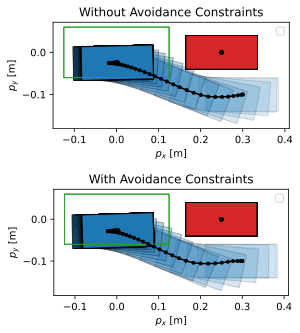

In [151]:
Nc = 3  # number of circles 
L = 0.17 # from parameters
W = 0.08 

solve_times = []

def constraint_function(x, obstacle):
    obstacle = (0.25, 0)
    p = (x[0], x[1])
    c, r = calculate_circles(p, x[2], L, W, Nc)
    co, ro = calculate_circles(obstacle, 0.0, L, W, Nc)
    constraints = [(r+ro)**2 - (c[i][0]-co[i][0])**2 - (c[i][1]-co[i][1])**2 for i in range(len(c))]
    return constraints

class MPCController:

    def __init__(self, N: int, ts: float, *, params: VehicleParameters, avoid_obs, weights, obs_func):
        self.N = N
        self.ts = ts 
        nlp_dict, self.bounds = self.build_ocp(params, avoid_obs, weights, obs_func)
        
        opts = {"ipopt": {"print_level": 1}, "print_time": False}
        self.ipopt_solver = cs.nlpsol("solver", "ipopt", nlp_dict, opts) 
        
    def solve(self, x) -> dict:
        return self.ipopt_solver(p=x, **self.bounds)
        
    def build_ocp(self, params: VehicleParameters, avoid_obs, weights, obs_func) -> Tuple[dict, dict]:
        Q, QT, R = weights

        # Create a parameter for the initial state. 
        x0 = cs.SX.sym("x0", (4,1))
        
        # controls 
        u = [cs.SX.sym(f"u_{i}", (2,1)) for i in range(self.N)]

        # discretization
        model = KinematicBicycle(params, symbolic=True)
        f = forward_euler(model, self.ts)

        # cost 
        # single shooting
        states = []
        cost = 0 
        x = x0 
        for i in range(self.N):
            cost += x.T @ Q @ x + u[i].T @ R @ u[i]
            x = f(x,u[i])
            states.append(x)
        
        cost += x.T @ QT @ x 

        # constraints
        lb_state = self.N * [params.min_pos_x, params.min_pos_y, params.min_heading, params.min_vel]
        ub_state = self.N * [params.max_pos_x, params.max_pos_y, params.max_heading, params.max_vel]
        lb_u = self.N * [params.min_drive, -params.max_steer]
        ub_u = self.N * [params.max_drive, params.max_steer]

        # The obstacle contraint
        obs_g = []
        ub_obs_g = []  
        lb_obs_g = [] 
        if avoid_obs:
            for x_k in states:
                obs_g += obs_func(x_k)
            
            # the last state 
            obs_g += obs_func(x)

            ub_obs_g = [0] * len(obs_g)
            lb_obs_g = [-100] * len(obs_g)

        nlp = {"f": cost,
            "x": cs.vertcat(*u),
            "g": cs.vertcat(*(states + obs_g)),
            "p": x0}
        
        bounds = {"lbx": cs.vertcat(*lb_u),
                "ubx": cs.vertcat(*ub_u),
                "lbg": cs.vertcat(*(lb_state + lb_obs_g)),
                "ubg": cs.vertcat(*(ub_state + ub_obs_g)),
                }
        # constraints
        
        return nlp, bounds

    def reshape_input(self, sol):
        return np.reshape(sol["x"], ((-1, 2)))

    def __call__(self, y):
        """Solve the OCP for initial state y.

        Args:
            y (np.ndarray): Measured state 
        """
        start = perf_counter()
        solution = self.solve(y)
        end = perf_counter()

        global solve_times
        solve_times.append(end-start)
        u = self.reshape_input(solution)
        return u[0]
    
    
N=30
ts = 0.08
x0 = np.array([0.3, -0.1, 0, 0])
Q = cs.diagcat(1, 3, 0.1, 0.01)
QT = 5 * Q 
R = cs.diagcat(1, 1e-2)
obstacle = (0.25, -0.00)
obs_func = lambda x: constraint_function(x, obstacle)

# Build the assumed model
nstep = 100
model = KinematicBicycle(VehicleParameters())
disc_dyn = forward_euler(model, ts)

# MPC without avoidance 
solve_times = []
mpc = MPCController(N=N, ts=ts, params=VehicleParameters(), avoid_obs=False, weights=(Q,QT,R), obs_func=obs_func)
x_sim_no_avoid = simulate(x0, disc_dyn, n_steps=nstep, policy=mpc)

# MPC with avoidance
solve_times = []
mpc = MPCController(N=N, ts=ts, params=VehicleParameters(), avoid_obs=True, weights=(Q,QT,R), obs_func=obs_func)
x_sim_avoid = simulate(x0, disc_dyn, n_steps=nstep, policy=mpc)

x_obs = np.array([[obstacle[0], obstacle[1], 0, 0]]).repeat(nstep+1, 0)
plt.figure()
plt.subplot(2,1,1)
plot_state_trajectory(x_sim_no_avoid, color="tab:blue")
plot_state_trajectory(x_obs, color="tab:red")
plt.title("Without Avoidance Constraints")

plt.subplot(2,1,2)
plot_state_trajectory(x_sim_avoid, color="tab:blue")
plot_state_trajectory(x_obs, color="tab:red")
plt.title("With Avoidance Constraints")
plt.tight_layout()
# plt.savefig("figs/4.4.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()



In [ ]:
anim = AnimateParking()
anim.setup(x_sim_avoid, ts, obstacle_positions=x_obs[:,0:2])
# anim.add_car_trajectory(x_sim_avoid, color=(150, 10, 50))
anim.trace(x_sim_avoid)
anim.run()

## Assignment 4.5

C:\Users\msaad\AppData\Local\Temp\ipykernel_13376\1483678177.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


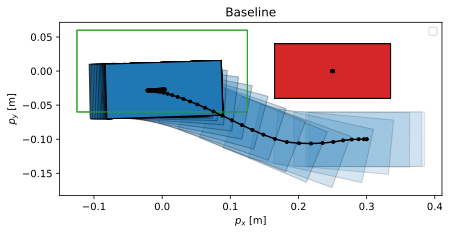

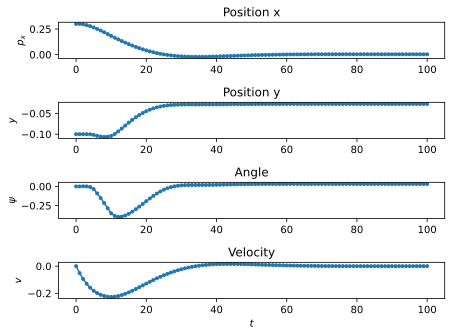

In [ ]:
# Baseline

N=30
ts = 0.08
x0 = np.array([0.3, -0.1, 0, 0])
Q = cs.diagcat(1, 3, 0.1, 0.01)
QT = 5 * Q 
R = cs.diagcat(1, 1e-2)
obstacle = (0.25, -0.00)
obs_func = lambda x: constraint_function(x, obstacle) 

# Build the assumed model
nstep = 100
model = KinematicBicycle(VehicleParameters())
disc_dyn = forward_euler(model, ts)

# MPC with avoidance
mpc = MPCController(N=N, ts=ts, params=VehicleParameters(), avoid_obs=True, weights=(Q,QT,R), obs_func=obs_func)
x_sim_avoid = simulate(x0, disc_dyn, n_steps=nstep, policy=mpc, log=None)

x_obs = np.array([[obstacle[0], obstacle[1], 0, 0]]).repeat(nstep+1, 0)
plt.figure()
plot_state_trajectory(x_sim_avoid, color="tab:blue")
plot_state_trajectory(x_obs, color="tab:red")
plt.title("Baseline")
plt.tight_layout()
plt.show()

plot_states_separately(x_sim_avoid)
plt.show()

d:\Studies\MSEE\KULeuven\Semester 3\Model Predictive Control\MPC-Project\.venv\lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\msaad\AppData\Local\Temp\ipykernel_13376\990758098.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


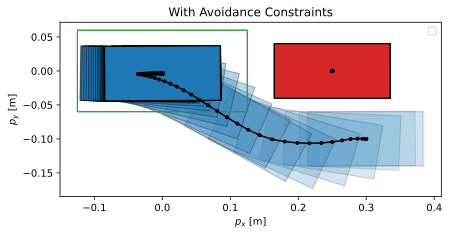

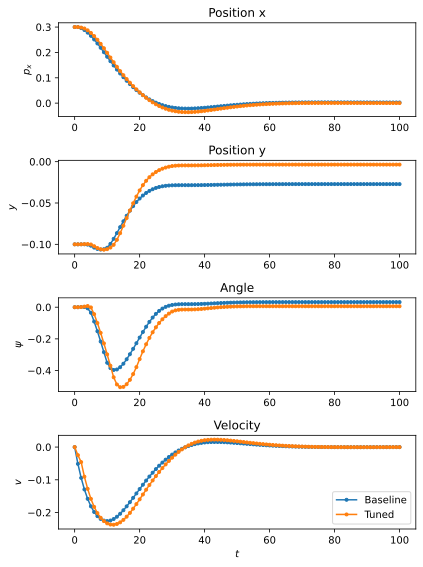

In [164]:
# TUNED

N=30
ts = 0.08
x0 = np.array([0.3, -0.1, 0, 0])
Q = cs.diagcat(1, 3, 0.1, 0.01)
QT = 5 * Q; QT[2,2] *= 50; QT[1,1] *= 50;
R = cs.diagcat(1, 1e-2)
obstacle = (0.25, -0.00)
obs_func = lambda x: constraint_function(x, obstacle)

# Build the assumed model
nstep = 100
model = KinematicBicycle(VehicleParameters())
disc_dyn = forward_euler(model, ts)

# MPC with avoidance
solve_times = []
mpc = MPCController(N=N, ts=ts, params=VehicleParameters(), avoid_obs=True, weights=(Q,QT,R), obs_func=obs_func)
x_sim_avoid_tuned = simulate(x0, disc_dyn, n_steps=nstep, policy=mpc)

x_obs = np.array([[obstacle[0], obstacle[1], 0, 0]]).repeat(nstep+1, 0)
plt.figure()
plot_state_trajectory(x_sim_avoid_tuned, color="tab:blue")
plot_state_trajectory(x_obs, color="tab:red")
plt.title("With Avoidance Constraints")
plt.tight_layout()
# plt.savefig("figs/4.5-1.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.figure(figsize=(6,8))
plot_states_separately(x_sim_avoid)
plot_states_separately(x_sim_avoid_tuned)
plt.legend(["Baseline", "Tuned"])
# plt.savefig("figs/4.5-2.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

## Assignment 4.6

d:\Studies\MSEE\KULeuven\Semester 3\Model Predictive Control\MPC-Project\.venv\lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

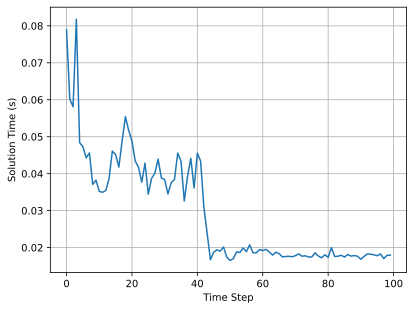

C:\Users\msaad\AppData\Local\Temp\ipykernel_13376\990758098.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


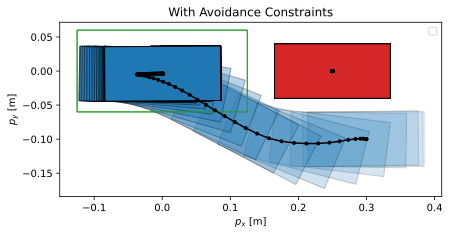

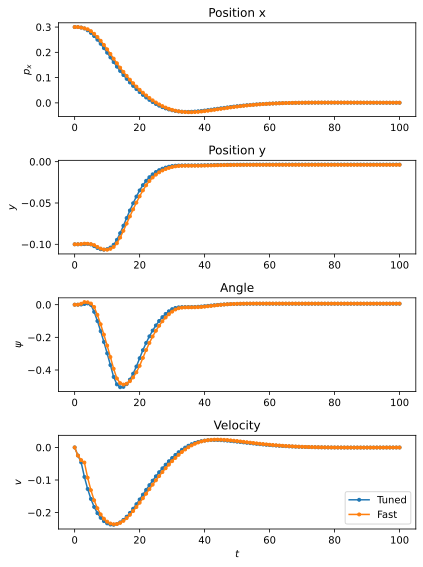

In [ ]:
# Timing

N=25
ts = 0.08
x0 = np.array([0.3, -0.1, 0, 0])
Q = cs.diagcat(1, 3, 0.1, 0.01)
QT = 5 * Q; QT[2,2] *= 50; QT[1,1] *= 50;
R = cs.diagcat(1, 1e-2)
obstacle = (0.25, -0.00)
obs_func = lambda x: constraint_function(x, obstacle)

# Build the assumed model
nstep = 100
model = KinematicBicycle(VehicleParameters())
disc_dyn = forward_euler(model, ts)

# MPC with avoidance
solve_times = []
mpc = MPCController(N=N, ts=ts, params=VehicleParameters(), avoid_obs=True, weights=(Q,QT,R), obs_func=obs_func)
x_sim_avoid_fast = simulate(x0, disc_dyn, n_steps=nstep, policy=mpc)

plt.plot(solve_times)
plt.grid(True)
plt.xlabel("Time Step")
plt.ylabel("Solution Time (s)")
# plt.savefig("figs/4.6-time.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

x_obs = np.array([[obstacle[0], obstacle[1], 0, 0]]).repeat(nstep+1, 0)
plt.figure()
plot_state_trajectory(x_sim_avoid_fast, color="tab:blue")
plot_state_trajectory(x_obs, color="tab:red")
plt.title("With Avoidance Constraints")
plt.tight_layout()
# plt.savefig("figs/4.5-1.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.figure(figsize=(6,8))
plot_states_separately(x_sim_avoid_tuned)
plot_states_separately(x_sim_avoid_fast)
plt.legend(["Tuned", "Fast"])
# plt.savefig("figs/4.6-Fast.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()